In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import gamma
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

This notebook aims to visualize the factorized variational approximate distribution for a Gaussian-Gamma distribution as described by Christopher Bishop in his book "Pattern Recognition and Machine Learning" pp 470

# Likelihood

Assume a Gaussian distribution as likelihood with mean $\mu$ and precision $\tau$ and let $\mathcal{D} = \{x_1, ... , x_N\}$ be the dataset. Then, the likelihood of this dataset is 
\
\begin{equation}
p\left(\mathcal{D} \rvert \mu, \tau \right) = \mathcal{N}\left(\mathcal{D} \rvert \mu, \tau \right) = \frac{1}{\left(2 \pi\right)^{\frac{N}{2}}} \tau^{\frac{N}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left(\sum_{i=1}^{N}\left (x_i - \mu \right)^2 \right)\right).
\end{equation}

This equation can be simplified for later calculations by introducing the empirical mean $\bar{x} = \frac{1}{N} \sum_{i = 1}^{N} x_i$ of the dataset $\mathcal{D} =\{x_1, ..., x_N \}$ so that

\begin{equation}
\begin{aligned}
\sum_{i = 1}^{N} \left( x_i - \mu \right)^2 &= \sum_{i = 1}^{N} \left( x_i - \mu + \underbrace{\bar{x} - \bar{x}}_{= 0} \right) \\
&= \sum_{i=1}^{N}\left( \left(x_i - \bar{x} \right) - \left(\mu - \bar{x} \right) \right)^2 \\
&= \sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 - 2 \left(\mu - \bar{x}\right) \sum_{i=1}^{N}\left(x_i - \bar{x}\right) + \sum_{i=1}^{N}\left(\mu - \bar{x} \right)^2 \\
&= \sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 - 2 \left(\mu - \bar{x}\right) \left( \underbrace{ \underbrace{\sum_{i=1}^{N}x_i}_{=N \bar{x}} - N \bar{x}}_{=0} \right) + \sum_{i=1}^{N}\left(\mu - \bar{x} \right)^2 \\
&= \sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 + \sum_{i=1}^{N}\left(\mu - \bar{x} \right)^2 \\
&= \sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 + \underbrace{\sum_{i=1}^{N} \mu^2}_{N \mu^2} + 2 \underbrace{\sum_{i=1}^{N} \mu \bar{x}}_{N \mu \bar{x}} + \underbrace{\sum_{i=1}^{N} \bar{x}^2}_{N \bar{x}^2} \\
&= \sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 + N \mu^2 + 2 N \mu \bar{x} + N \bar{x}^2.
\end{aligned}
\end{equation}

Therefore, the likelihood can be rewritten as 

\begin{equation}
p\left(\mathcal{D} \rvert \mu, \tau \right) = \mathcal{N}\left(\mathcal{D} \rvert \mu, \tau \right) = \frac{1}{\left(2 \pi\right)^{\frac{N}{2}}} \tau^{\frac{N}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 + N \mu^2 + 2 N \mu \bar{x} + N \bar{x}^2\right) \right).
\end{equation}


In [2]:
x_data = np.linspace(-1, 1, 5)
N = len(x_data)
x_mean = 1/N * np.sum(x_data, axis = 0)


# Prior Distribution on the mean $\mu$

As prior distribution on the mean $\mu$ a Gaussian distribution

\begin{equation}
p\left(\mu \rvert \tau \right) = \mathcal{N}\left(\mu \rvert \mu_0, \left( \lambda_0 \tau \right)^{-1} \right) = \frac{1}{\left(2 \pi\right)^{\frac{1}{2}}} \lambda_0^{\frac{1}{2}}\tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\lambda_0 \tau}{2}\left( \mu - \mu_0 \right)^2 \right)
\end{equation}

is assumed.


Text(0, 0.5, 'density')

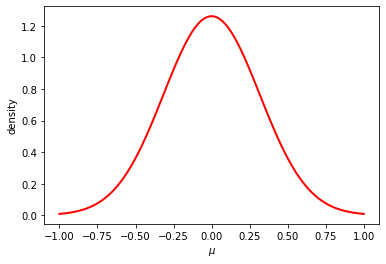

In [3]:
mu_data = np.linspace(-1, 1, 100)
mu_0 = 0.0
lmbda_0 = 1
tau_dummy = 10

prior_on_mu = norm.pdf(mu_data, loc = mu_0, scale = 1 / np.sqrt(lmbda_0*tau_dummy))

fig, ax = plt.subplots(1, 1)
ax.plot(mu_data, prior_on_mu,'r-', lw=2, label='prior_on_mu')
ax.set_xlabel('$\mu$')
ax.set_ylabel('density')

# Prior Distribution on the precision $\tau$


As prior distribution on the precision $\tau$ a Gamma distribution

\begin{equation}
p \left( \tau \right) = \mathrm{Gam}\left(\tau \rvert a_0, b_0 \right) = \frac{1}{\Gamma \left(a_0 \right)} b_0^{a_0} \tau^{a_0-1} \mathrm{exp}\left(-b_0 \tau \right)
\end{equation}

is assumed.

Text(0, 0.5, 'density')

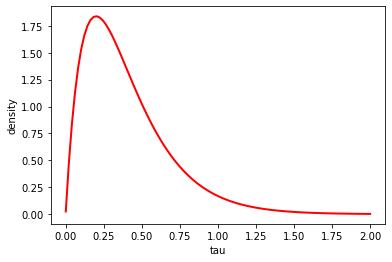

In [4]:
tau_data = np.linspace(0.001, 2, 100)
a_0 = 2
b_0 = 5

prior_on_tau = gamma.pdf(tau_data, a_0, scale = 1 / b_0)

fig, ax = plt.subplots(1, 1)
ax.plot(tau_data, prior_on_tau,'r-', lw=2, label='prior_on_tau')
ax.set_xlabel('tau')
ax.set_ylabel('density')

# True Posterior Distribution


Knowing the likelihood $p\left(\mathcal{D} \rvert \mu, \tau \right)$, the prior distribution on the mean $p\left( \mu \rvert \tau \right)$, and the prior distribution on the precision $p \left(\tau\right)$, the posterior distribution over the mean and the precision given the data can be inferred using Bayes' Theorem

\begin{equation}
\begin{aligned}
p \left(\mu, \tau \rvert \mathcal{D}\right) = \frac{p \left( \mathcal{D}, \mu, \tau \right)}{p\left(\tau \right)} &= \frac{p \left(\mathcal{D} \rvert \mu, \tau \right) p\left(\mu \rvert \tau\right) p \left( \tau \right)}{p \left( \mathcal{D} \right)} \\
& \propto p \left(\mathcal{D} \rvert \mu, \tau \right) p\left(\mu \rvert \tau\right) p \left( \tau \right) \\
& \propto \mathcal{N}\left(\mathcal{D} \rvert \mu, \tau \right) \mathcal{N}\left(\mu \rvert \mu_0, \left( \lambda_0 \tau \right)^{-1} \right) \mathrm{Gam}\left(\tau \rvert a_0, b_0 \right) \\
& \propto \underbrace{\frac{1}{\left(2 \pi\right)^{\frac{N}{2}}}}_{= const.} \tau^{\frac{N}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left(\sum_{i=1}^{N}\left (x_i - \mu \right)^2 \right)\right) \underbrace{\frac{1}{\left(2 \pi\right)^{\frac{1}{2}}} \lambda_0^{\frac{1}{2}}}_{= const.} \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\lambda_0 \tau}{2}\left( \mu - \mu_0 \right)^2 \right) \underbrace{\frac{1}{\Gamma \left(a_0 \right)} b_0^{a_0}}_{= const.} \tau^{a_0-1} \mathrm{exp}\left(-b_0 \tau \right) \\
& \propto \tau^{\frac{N}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 + N \mu^2 + 2 N \mu \bar{x} + N \bar{x}^2 \right) \right)  \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\lambda_0 \tau}{2}\left( \mu - \mu_0 \right)^2 \right)  \tau^{a_0-1} \mathrm{exp}\left(-b_0 \tau \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left(N \mu^2 + 2 N \mu \bar{x} + N \bar{x}^2\right) \right)   \mathrm{exp}\left(-\frac{\tau}{2} \left( \lambda_0 \left( \mu - \mu_0 \right)^2 \right) \right)  \tau^{a_0-1} \tau^{\frac{N}{2}}\mathrm{exp}\left(-b_0 \tau \right) \mathrm{exp} \left( -\frac{\tau}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \lambda_0 \left( \mu - \mu_0 \right)^2 + N \mu^2 + 2 N \mu \bar{x} + N \bar{x}^2\right) \right) \tau^{\underbrace{a_0 + \frac{N}{2}}_{=\alpha} - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \left(N + \lambda_0 \right)\mu^2 - 2 \mu \left(N \bar{x} + \lambda_0 \mu_0 \right)  + N \bar{x}^2 + \lambda_0 \mu_0^2 \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \left(N + \lambda_0 \right)\left(\mu^2 - 2 \mu \underbrace{\frac{N \bar{x} + \lambda_0 \mu_0}{N + \lambda_0}}_{= m } + \underbrace{0}_{m^2 - m^2} \right) + N \bar{x}^2 + \lambda_0 \mu_0^2 \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \left(N + \lambda_0 \right)\underbrace{\left(\mu^2 - 2 \mu m + m^2\right)}_{\left( \mu - m \right)^2} - \left(N + \lambda_0 \right) m^2  + N \bar{x}^2 + \lambda_0 \mu_0^2 \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \left(N + \lambda_0 \right)\left( \mu - m \right)^2 - \underbrace{\left(N + \lambda_0 \right) m^2}_{\frac{\left(N \bar{x} + \lambda_0 \mu_0\right)^2}{N + \lambda_0}}  + N \bar{x}^2 \frac{N + \lambda_0}{N + \lambda_0} + \lambda_0 \mu_0^2 \frac{N + \lambda_0}{N + \lambda_0} \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \left(N + \lambda_0 \right)\left( \mu - m \right)^2 + \frac{1}{N + \lambda_0}\left( \underbrace{ N^2 \bar{x}^2 - N^2 \bar{x}^2+ \lambda_0^2 \mu_0^2 - \lambda_0^2 \mu_0^2}_{=0}  + \lambda_0 N \underbrace{\left(\bar{x}^2 - 2 \bar{x} \mu_0 + \mu_0^2 \right)}_{\left(\bar{x} - \mu_0\right)^2} \right) \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau}{2}\left( \underbrace{\left(N + \lambda_0 \right)}_{= \lambda}\left( \mu - m \right)^2 + \frac{\lambda_0 N \left(\bar{x} - \mu_0\right)^2}{N + \lambda_0} \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 \right)\right) \right) \\
& \propto \tau^{\frac{1}{2}} \mathrm{exp}\left(-\frac{\tau \lambda}{2}\left( \left( \mu - m \right)^2 \right) \right) \tau^{\alpha - 1}\mathrm{exp}\left(- \tau \left(\underbrace{b_0 + \frac{1}{2}\left(\sum_{i=1}^{N}\left(x_i - \bar{x} \right)^2 + \frac{\lambda_0 N \left(\bar{x} - \mu_0\right)^2}{N + \lambda_0} \right)}_{= \beta}\right) \right) \\
\end{aligned}
\end{equation}



With $\lambda = N + \lambda_0 $, $ m = \frac{N \bar{x}+ \lambda_0 \mu_0}{\lambda}$, $\alpha = a_0 + \frac{N}{2} $,  and $\beta = b_0 + \frac{1}{2} \left( \sum_{i=1}^{N} \left(x_i - \bar{x} \right)^2 + \frac{N \lambda_0 \left( \bar{x} - \mu_0 \right)^2}{N + \lambda_0} \right)$ we can identify the true posterior distribution over  $\mu$ and $\tau$ as a Gaussian-Gamma distribution

\begin{equation}
p \left( \mu, \tau \rvert \mathcal{D} \right) = \mathcal{N}\left(\mu \rvert m, \left(\tau \lambda\right)^{-1} \right) \mathrm{Gam} \left(\tau \rvert \alpha, \beta \right)
\end{equation}



In [5]:
# Parameters of the true posterior
lmbda = N + lmbda_0
m = (N * x_mean + lmbda_0 * mu_0) / lmbda
alpha = a_0 + N/2
beta = b_0 + 1/2 * (np.sum(x_data - x_mean, axis = 0)**2 + (N * lmbda_0 * (x_mean - mu_0)**2) / lmbda)

mu_Data, tau_Data = np.meshgrid(mu_data, tau_data)
pos = np.dstack((mu_Data, tau_Data))

true_posterior = norm.pdf(pos[:,:,0], loc = m, scale = 1 / np.sqrt(lmbda * pos[:,:,1])) * gamma.pdf(pos[:,:,1], alpha, scale = 1 / beta)

Text(0.5, 1.0, 'True Posterior Distribution')

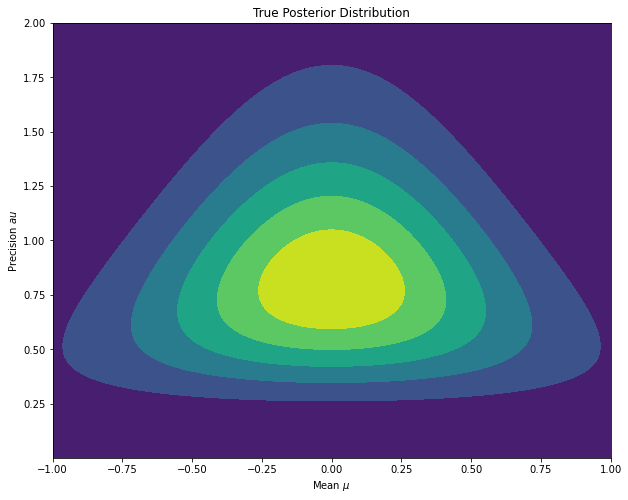

In [6]:
fig, (axs) = plt.subplots(1, 1, figsize=(10, 8), tight_layout= False)

axs.contourf(mu_Data, tau_Data, true_posterior)
axs.set_xlabel('Mean $\mu$')
axs.set_ylabel('Precision $\tau$')
axs.set_title('True Posterior Distribution')

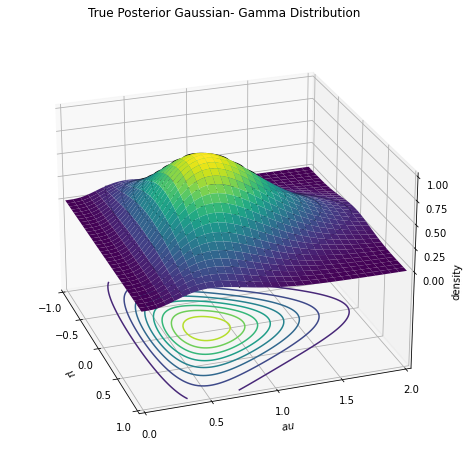

In [7]:
# Surface plot of True Posterior Distribution
fig =plt.figure(figsize=(10, 8), tight_layout= False)
ax = fig.gca(projection='3d')
ax.plot_surface(mu_Data, tau_Data, true_posterior, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax.contour(mu_Data, tau_Data, true_posterior, 10, cmap=cm.viridis, linestyles="solid", offset=-1)
ax.contour(mu_Data, tau_Data, true_posterior, 10, colors="k", linestyles="solid")
ax.set_xlim(-1,1)
ax.set_ylim(0,2)
ax.set_zlim(-1,1)
ax.set_xticks(np.linspace(-1,1,5))
ax.set_yticks(np.linspace(0,2,5))
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\tau$')
ax.set_zlabel('density')
ax.set_zticks(np.linspace(0,1,5))
ax.view_init(25, -19)
ax.set_title("True Posterior Gaussian- Gamma Distribution")

plt.show()

# Factorized Variational Approximation

Even though there exists a closed form expression for the posterior distribution, the technique of factorized variational approximation is now applied to visualize the procedure of approximating posterior distributions. Let $q(\mu, \tau)$ be the factorized variational approximation to the posterior distribution. Then, this approximate is can be written as

\begin{equation}
q\left(\mu, \tau \right) = q_{\mu}\left( \mu \right) q_{\tau} \left(\tau \right)
\end{equation}

The optimum factor for $\mu$ is 

\begin{equation}
q_{\mu}\left(\mu \right) = \mathcal{N}\left(\mu \rvert \mu_N, \lambda_N^{-1} \right)
\end{equation}

with $\lambda_N = \left( \lambda_0 + N \right) E\left[ \tau \right]$ and $\mu_N = \frac{\lambda_0 \mu_0 + N \bar{x}}{\lambda_0 + N}$

In [8]:
mu_N = (lmbda_0 * mu_0 + N * x_mean) / (lmbda_0 + N)

In [9]:
def opt_factor_mu(tau, lmbda_0, mu_0, N, x_mean, pos):
    mu = (lmbda_0 * mu_0 + N * x_mean) / (lmbda_0 + N)
    stdv = 1 / np.sqrt((lmbda_0 + N)*tau)
    mu_var = stdv**2
    q_mu = norm.pdf(pos[:,:,0], loc = mu, scale = stdv)
    return q_mu, mu, mu_var

The optimum factor for $\tau$ is 

\begin{equation}
q_{\tau} = \mathrm{Gam} \left(\tau \rvert a_N, b_N \right)
\end{equation}

with $a_N = \frac{N+1}{2} a_0$ and $b_N = b_0 + \frac{1}{2} N \bar{x} - \left( 2 \mu_0 + N \bar{x} \right) E\left[\mu \right] + \frac{N + \lambda_0}{2} \left(\mathrm{var}\left[\mu \right] + E \left[\mu \right]^2 \right) + \frac{\mu_0^2}{2}$

In [10]:
def opt_factor_tau(mu, mu_var, N, x_mean, a_0, b_0, mu_0, pos):
    a_N = (N + 1) / 2 * a_0
    b_N = b_0 + 1/2 * N * x_mean - (2 * mu_0 + N * x_mean) * mu + (N + lmbda_0) / 2 * (mu_var + mu**2) + mu_0**2 / 2
    q_tau = gamma.pdf(pos[:,:,1], a_N, scale = 1 / b_N)
    tau_expected = a_N / b_N
    return q_tau, tau_expected

Now the factorized variational approximate distribution is received by  iterating the following algorithm:

1. Initialize $E \left[ \tau \right] $ of $q \left( \mu \right)$
2. While convergence criterion = True:
    1. Compute $q \left( \mu \right)$
    2. Extract $E \left[\mu \right]$ and $\mathrm{var}[\mu]$ from $q(\mu)$ 
    3. Compute $q\left( \tau \right)$
    4. Extract $E \left[ \tau \right] $ from $q(\tau) $
    
Note that the approximate posterior distribution gets close to the true posterior distribution but does not approximate it exactly.




















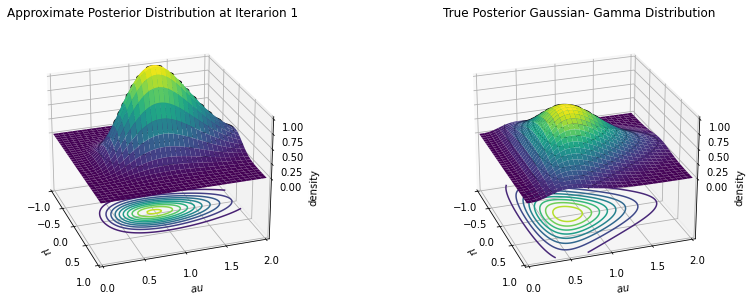

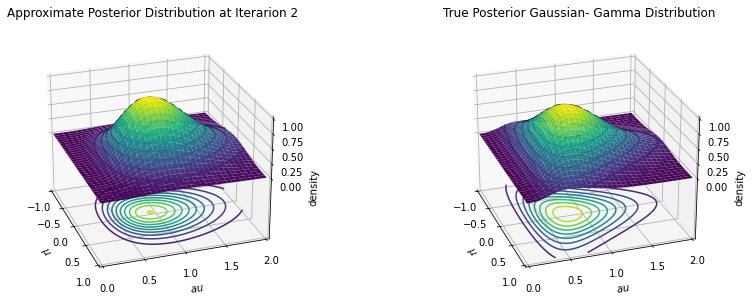

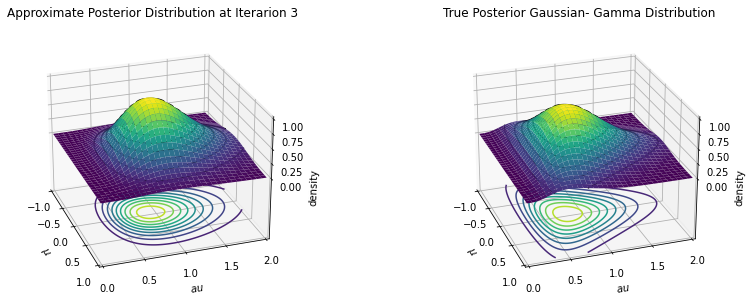

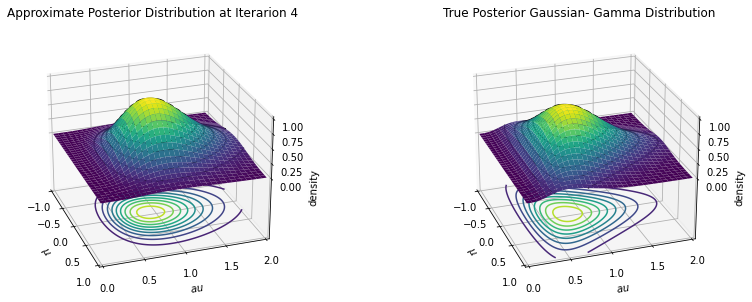

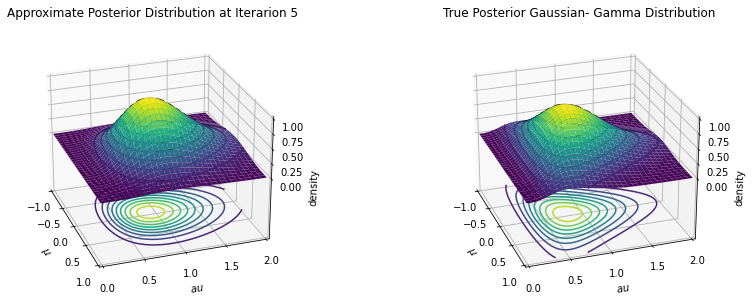

In [11]:
# Initialize expected value of tau
tau = 3
num_iterations = 5

for i in range(1, num_iterations + 1):
    q_mu, mu, mu_var = opt_factor_mu(tau, lmbda_0, mu_0, N, x_mean, pos)
    q_tau, tau = opt_factor_tau(mu, mu_var, N, x_mean, a_0, b_0, mu_0, pos)
    posterior_approx = q_mu * q_tau
    posterior_diff = np.abs(true_posterior - posterior_approx)

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=(14, 5), tight_layout= False)

    # Set up axes for first subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    ax = fig.gca(projection='3d')
    ax.plot_surface(mu_Data, tau_Data, posterior_approx, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.viridis)
    ax.contour(mu_Data, tau_Data, posterior_approx, 10, cmap=cm.viridis, linestyles="solid", offset=-1)
    ax.contour(mu_Data, tau_Data, posterior_approx, 10, colors="k", linestyles="solid")
    ax.set_xlim(-1,1)
    ax.set_ylim(0,2)
    ax.set_zlim(-1,1)
    ax.set_xticks(np.linspace(-1,1,5))
    ax.set_yticks(np.linspace(0,2,5))
    ax.set_zticks(np.linspace(0,1,5))
    ax.set_xlabel('$\mu$')
    ax.set_ylabel('$\tau$')
    ax.set_zlabel('density')
    ax.view_init(25, -19)
    ax.set_title("Approximate Posterior Distribution at Iterarion {}".format(i))

    # Set up axes for second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.plot_surface(mu_Data, tau_Data, true_posterior, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.viridis)
    ax.contour(mu_Data, tau_Data, true_posterior, 10, cmap=cm.viridis, linestyles="solid", offset=-1)
    ax.contour(mu_Data, tau_Data, true_posterior, 10, colors="k", linestyles="solid")
    ax.set_xlim(-1,1)
    ax.set_ylim(0,2)
    ax.set_zlim(-1,1)
    ax.set_xticks(np.linspace(-1,1,5))
    ax.set_yticks(np.linspace(0,2,5))
    ax.set_zticks(np.linspace(0,1,5))
    ax.set_xlabel('$\mu$')
    ax.set_ylabel('$\tau$')
    ax.set_zlabel('density')
    ax.view_init(25, -19)
    ax.set_title("True Posterior Gaussian- Gamma Distribution")

    plt.show()

